# Stochastic optimization landscape of a minimal MLP


In this notebook, we will try to better understand how stochastic gradient works. We fit a very simple non-convex model to data generated from a linear ground truth model.

We will also observe how the (stochastic) loss landscape changes when selecting different samples.

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.nn.functional import mse_loss
from torch.autograd import Variable
from torch.nn.functional import relu

Data is generated from a simple model:
$$y=  2x + \epsilon$$

where:

- $\epsilon \sim \mathcal{N}(0, 3)$
- $x \sim \mathcal{U}(-1, 1)$

In [0]:
def sample_from_ground_truth(n_samples=100, std=0.1):
    x = torch.FloatTensor(n_samples, 1).uniform_(-1, 1)
    epsilon = torch.FloatTensor(n_samples, 1).normal_(0, std)
    y = 2 * x + epsilon
    return x, y

n_samples = 100
std = 3
x, y = sample_from_ground_truth(n_samples=100, std=std)

We propose a minimal single hidden layer perceptron model with a single hidden unit and no bias. The model has two tunable parameters $w_1$, and $w_2$, such that:

$$f(x) = w_1 \cdot \sigma(w_2 \cdot x)$$

where $\sigma$ is the ReLU function.

In [0]:
class SimpleMLP(nn.Module):

    def __init__(self, w=None):
        super(SimpleMLP, self).__init__()
        self.w1 = Parameter(torch.FloatTensor((1,)))
        self.w2 = Parameter(torch.FloatTensor((1,)))
        if w is None:
            self.reset_parameters()
        else:
            self.set_parameters(w)

    def reset_parameters(self):
        self.w1.uniform_(-.1, .1)
        self.w2.uniform_(-.1, .1)

    def set_parameters(self, w):
        with torch.no_grad():
            self.w1[0] = w[0]
            self.w2[0] = w[1]

    def forward(self, x):
        return self.w1 * relu(self.w2 * x)        

As in the previous notebook, we define a function to sample from and plot loss landscapes.

In [0]:
from math import fabs


def make_grids(x, y, model_constructor, expected_risk_func, grid_size=100):
    n_samples = len(x)
    assert len(x) == len(y)

    # Grid logic
    x_max, y_max, x_min, y_min = 5, 5, -5, -5
    w1 = np.linspace(x_min, x_max, grid_size, dtype=np.float32)
    w2 = np.linspace(y_min, y_max, grid_size, dtype=np.float32)
    W1, W2 = np.meshgrid(w1, w2)
    W = np.concatenate((W1[:, :, None], W2[:, :, None]), axis=2)
    W = torch.from_numpy(W)

    # We will store the results in this tensor
    risks = torch.FloatTensor(n_samples, grid_size, grid_size)
    expected_risk = torch.FloatTensor(grid_size, grid_size)

    with torch.no_grad():
        for i in range(grid_size):
            for j in range(grid_size):
                model = model_constructor(W[i, j])
                pred = model(x)
                loss = mse_loss(pred, y, reduce=False)
                risks[:, i, j] = loss.view(-1)
                expected_risk[i, j] = expected_risk_func(W[i, j, 0], W[i, j, 1])
        empirical_risk = torch.mean(risks, dim=0)
    
    return W1, W2, risks.numpy(), empirical_risk.numpy(), expected_risk.numpy()


def expected_risk_simple_mlp(w1, w2):
    """Question: Can you derive this your-self?"""
    return .5 * (8 / 3 - (4 / 3) * w1 * w2 + 1 / 3 * w1 ** 2 * w2 ** 2) + std ** 2

- `risks[k, i, j]` holds loss value $\ell(f(w_1^{(i)} , w_2^{(j)}, x_k), y_k)$ for a single data point $(x_k, y_k)$;

- `empirical_risk[i, j]` corresponds to the empirical risk averaged over the training data points:

$$ \frac{1}{n} \sum_{k=1}^{n} \ell(f(w_1^{(i)}, w_2^{(j)}, x_k), y_k)$$

In [5]:
W1, W2, risks, empirical_risk, expected_risk = make_grids(
    x, y, SimpleMLP, expected_risk_func=expected_risk_simple_mlp)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Let's define our train loop and train our model:

In [0]:
from torch.optim import SGD

def train(model, x, y, lr=.1, n_epochs=1):
    optimizer = SGD(model.parameters(), lr=lr)
    iterate_rec = []
    grad_rec = []
    for epoch in range(n_epochs):
        # Iterate over the dataset one sample at a time:
        # batch_size=1
        for this_x, this_y in zip(x, y):
            this_x = this_x[None, :]
            this_y = this_y[None, :]
            optimizer.zero_grad()
            pred = model(this_x)
            loss = mse_loss(pred, this_y)
            loss.backward()
            with torch.no_grad():
                iterate_rec.append([model.w1.clone()[0], model.w2.clone()[0]])
                grad_rec.append([model.w1.grad.clone()[0], model.w2.grad.clone()[0]])
            optimizer.step()
    return np.array(iterate_rec), np.array(grad_rec)

init = torch.FloatTensor([3, -4])
model = SimpleMLP(init)
iterate_rec, grad_rec = train(model, x, y, lr=.01)

In [7]:
print(iterate_rec[-1])

[-0.84534436 -2.64079   ]


We now plot:
- the point-wise risk at iteration $k$ on the left plot
- the total empirical risk on the center plot
- the expected risk on the right plot

Observe how empirical and expected risk differ, and how empirical risk minimization is not totally equivalent to expected risk minimization.

In [0]:
import matplotlib.colors as colors


class LevelsNormalize(colors.Normalize):
    def __init__(self, levels, clip=False):
        self.levels = levels
        vmin, vmax = levels[0], levels[-1]
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        quantiles = np.linspace(0, 1, len(self.levels))
        return np.ma.masked_array(np.interp(value, self.levels, quantiles))


def plot_map(W1, W2, risks, emp_risk, exp_risk, sample, iter_):
    all_risks = np.concatenate((emp_risk.ravel(), exp_risk.ravel()))
    x_center, y_center = emp_risk.shape[0] // 2, emp_risk.shape[1] // 2
    risk_at_center = exp_risk[x_center, y_center]
    low_levels = np.percentile(all_risks[all_risks <= risk_at_center],
                               q=np.linspace(0, 100, 11))
    high_levels = np.percentile(all_risks[all_risks > risk_at_center],
                                q=np.linspace(10, 100, 10))
    levels = np.concatenate((low_levels, high_levels))
    norm = LevelsNormalize(levels=levels)

    cmap = plt.get_cmap('RdBu_r')
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 4))
    risk_levels = levels.copy()
    risk_levels[0] = min(risks[sample].min(), risk_levels[0])
    risk_levels[-1] = max(risks[sample].max(), risk_levels[-1])
    ax1.contourf(W1, W2, risks[sample], levels=risk_levels,
                 norm=norm, cmap=cmap)
    ax1.scatter(iterate_rec[iter_, 0], iterate_rec[iter_, 1],
                color='orange')
    if any(grad_rec[iter_] != 0):
        ax1.arrow(iterate_rec[iter_, 0], iterate_rec[iter_, 1],
                  -0.1 * grad_rec[iter_, 0], -0.1 * grad_rec[iter_, 1],
                  head_width=0.3, head_length=0.5, fc='orange', ec='orange')
    ax1.set_title('Pointwise risk')
    ax2.contourf(W1, W2, emp_risk, levels=levels, norm=norm, cmap=cmap)
    ax2.plot(iterate_rec[:iter_ + 1, 0], iterate_rec[:iter_ + 1, 1],
             linestyle='-', marker='o', markersize=6,
             color='orange', linewidth=2, label='SGD trajectory')
    ax2.legend()
    ax2.set_title('Empirical risk')
    cf = ax3.contourf(W1, W2, exp_risk, levels=levels, norm=norm, cmap=cmap)
    ax3.scatter(iterate_rec[iter_, 0], iterate_rec[iter_, 1],
                color='orange', label='Current sample')
    ax3.set_title('Expected risk (ground truth)')
    plt.colorbar(cf, ax=ax3)
    ax3.legend()
    fig.suptitle('Iter %i, sample % i' % (iter_, sample))
    plt.show()

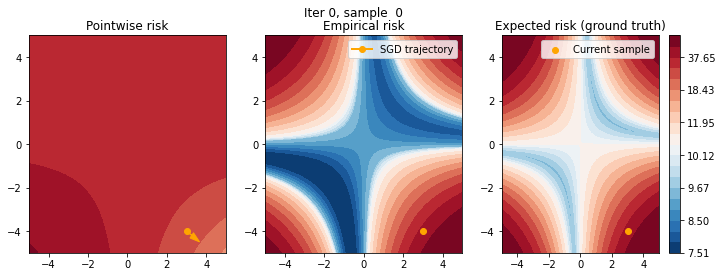

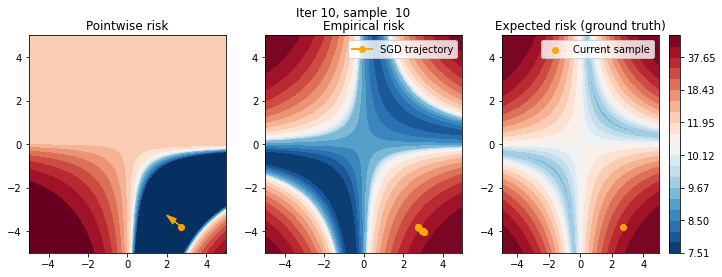

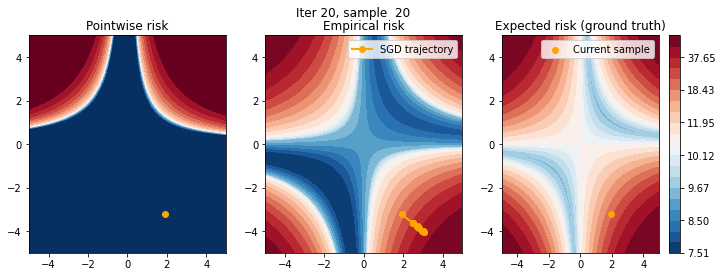

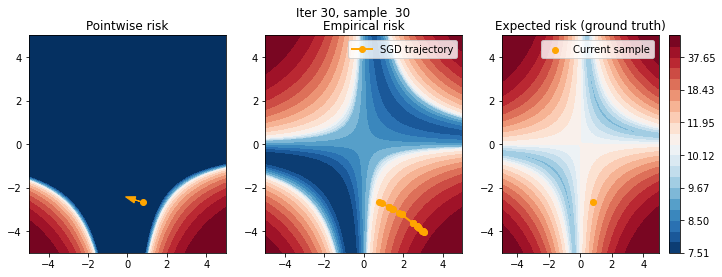

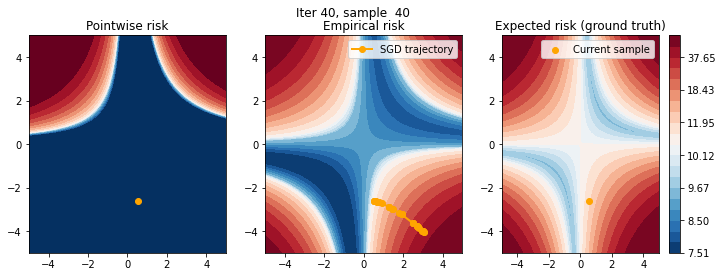

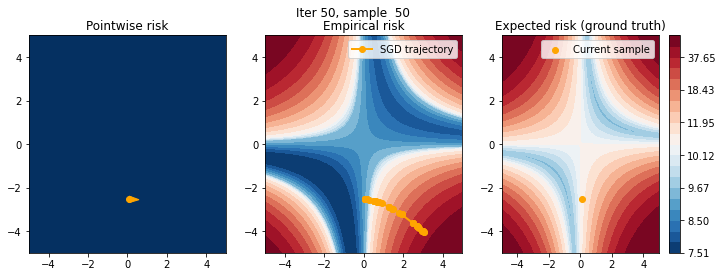

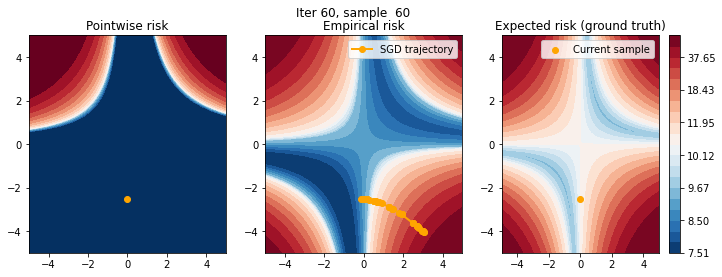

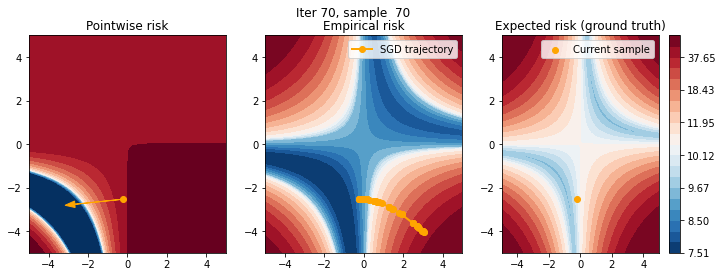

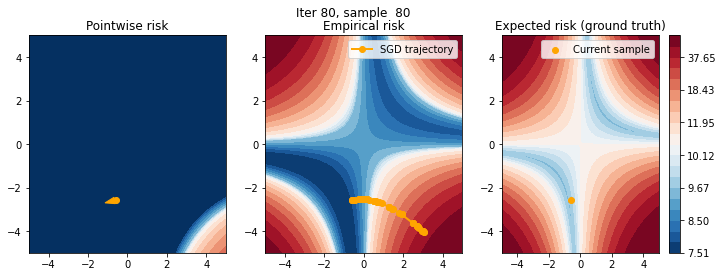

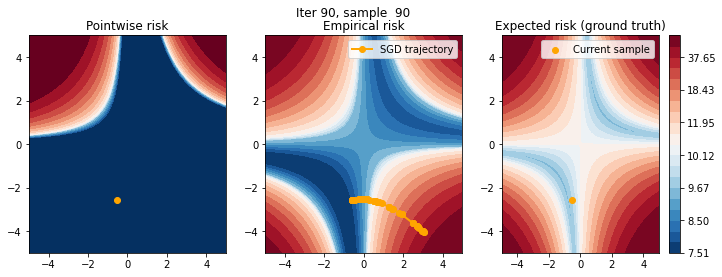

In [9]:
for sample in range(0, 100, 10):
    plot_map(W1, W2, risks, empirical_risk, expected_risk, sample, sample)

Observe and comment.

### Exercices:

- Change the model to a completely linear one and reproduce the plots. What change do you observe regarding the plot of the stochastic loss landscape?
- Try changing the optimizer. Is it useful in this case?
- Try to initialize the model with pathological weights, e.g., symmetric ones. What do you observe?
- You may increase the number of epochs to observe slow convergence phenomena
- Try augmenting the noise in the dataset. What do you observe?

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


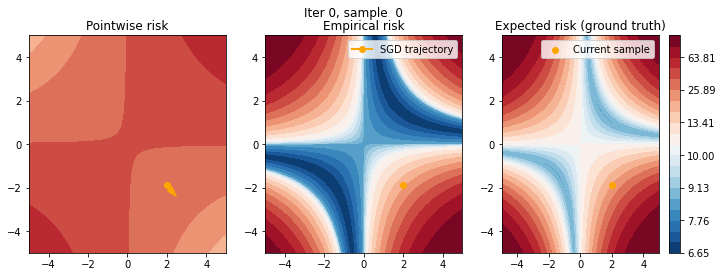

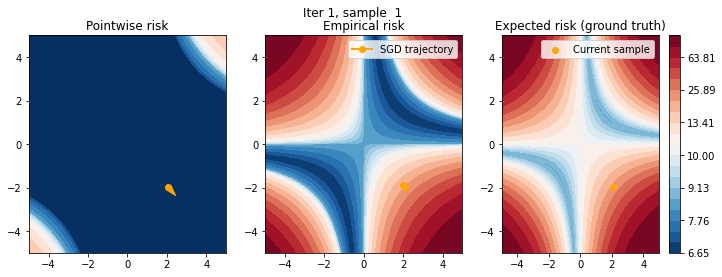

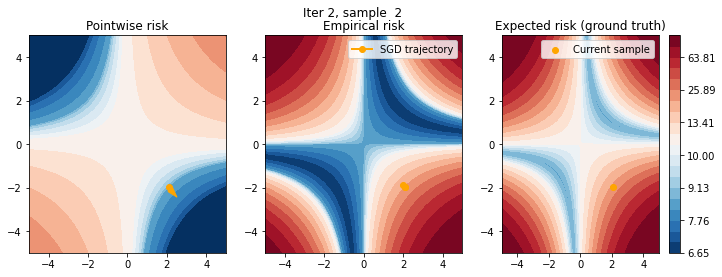

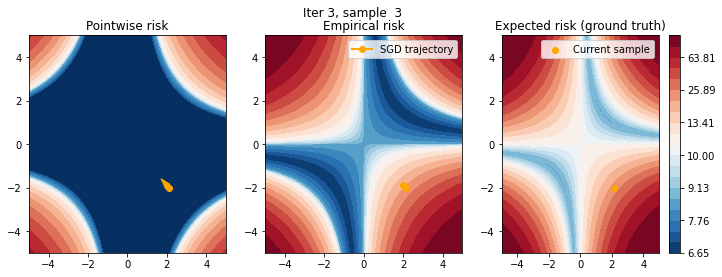

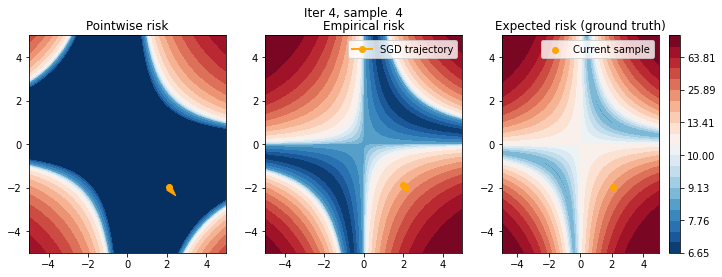

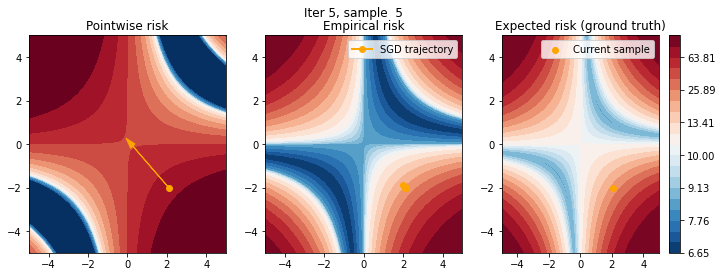

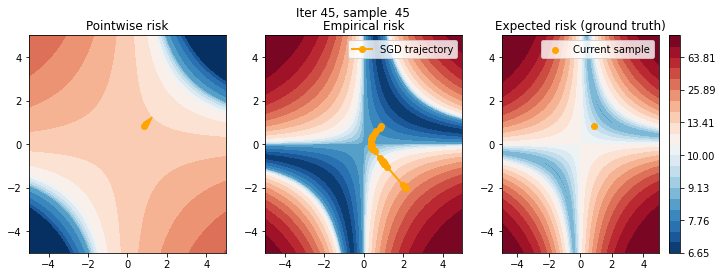

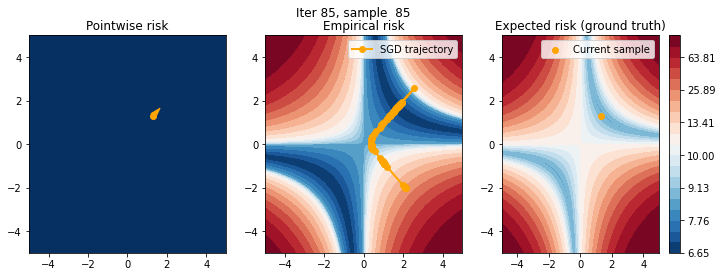

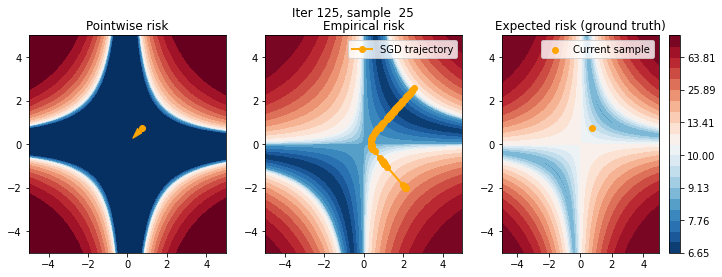

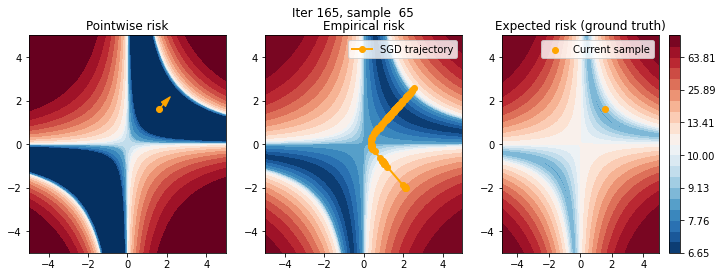

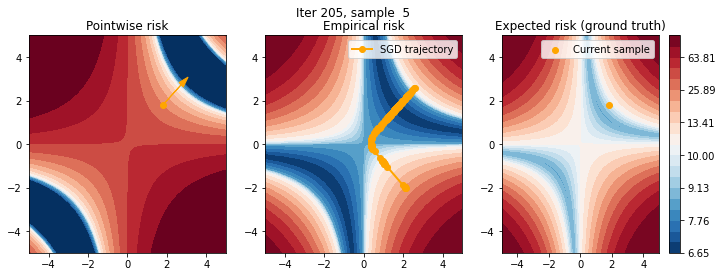

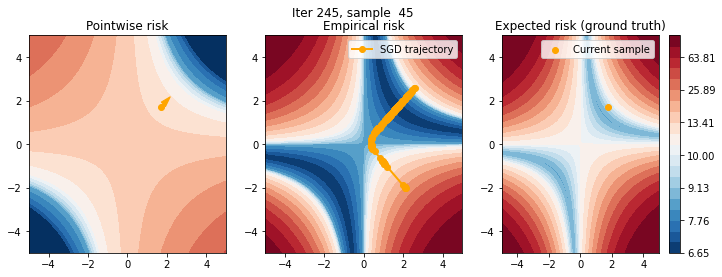

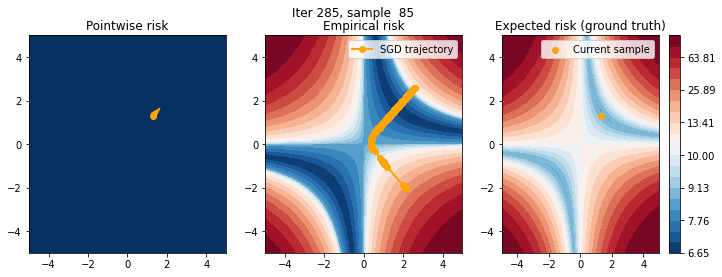

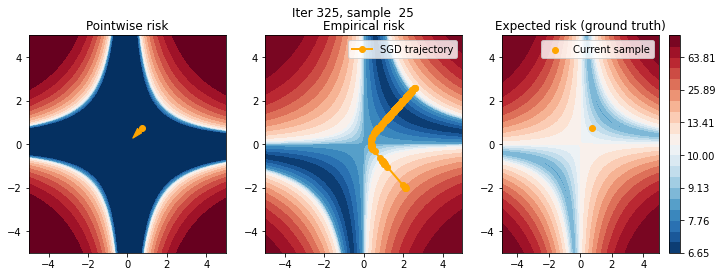

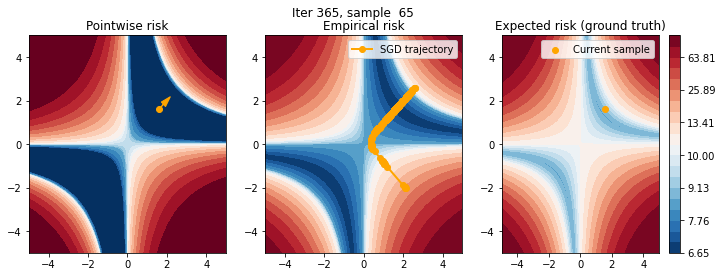

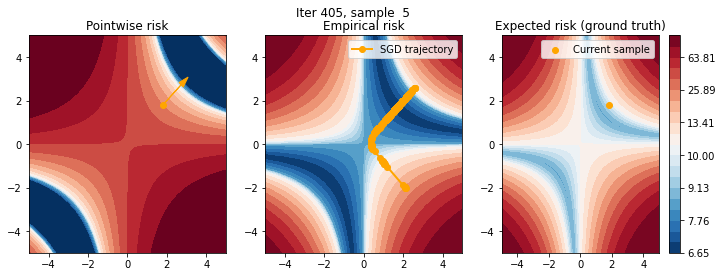

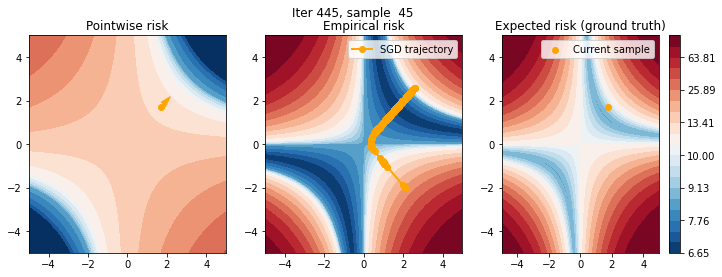

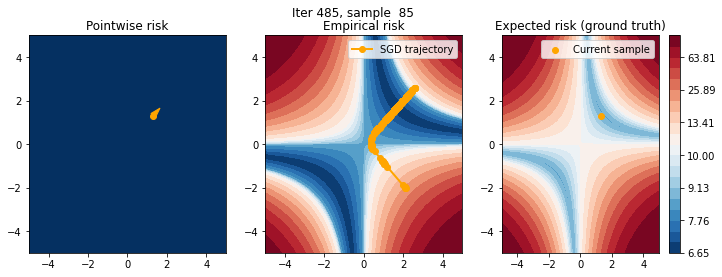

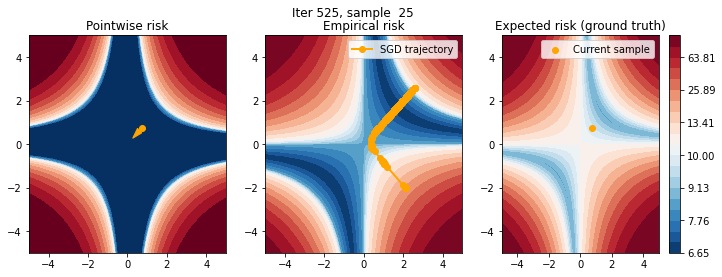

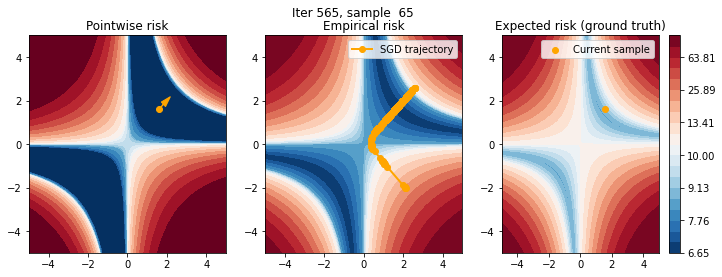

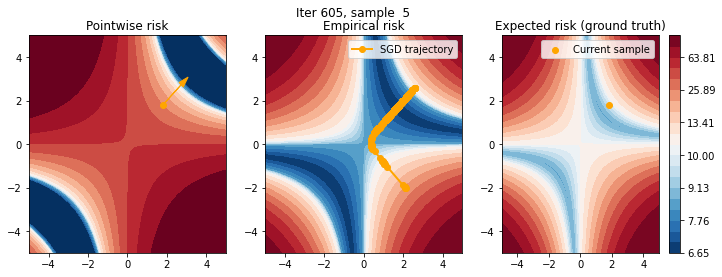

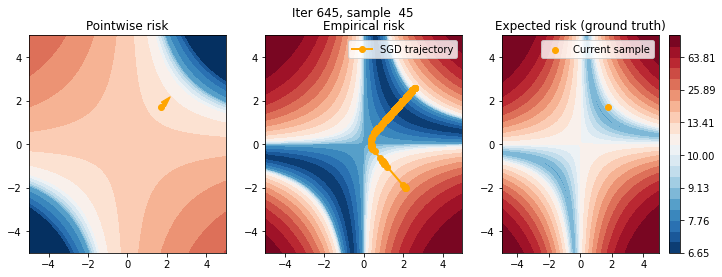

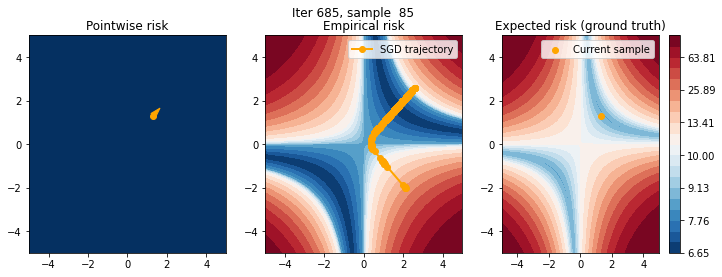

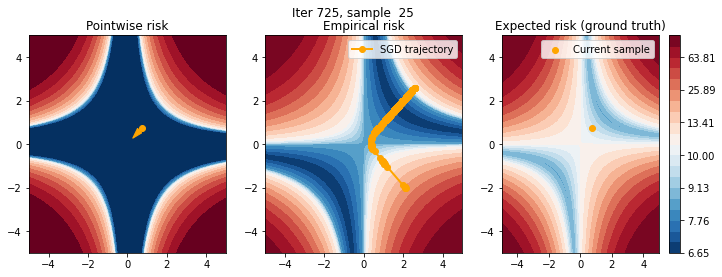

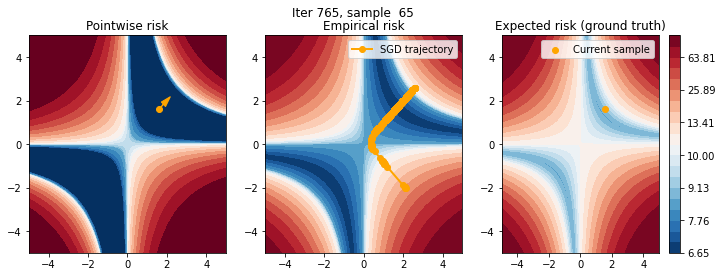

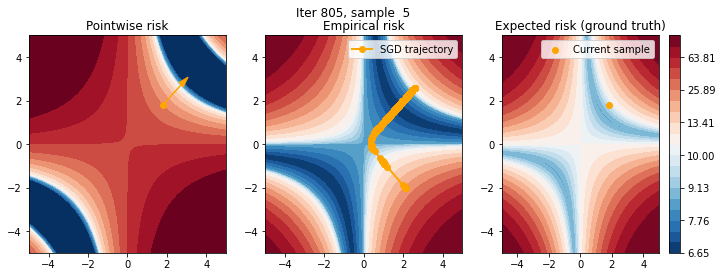

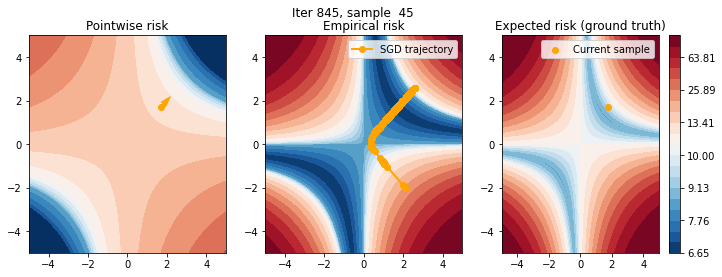

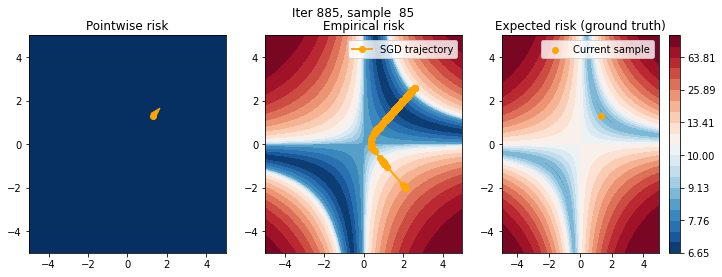

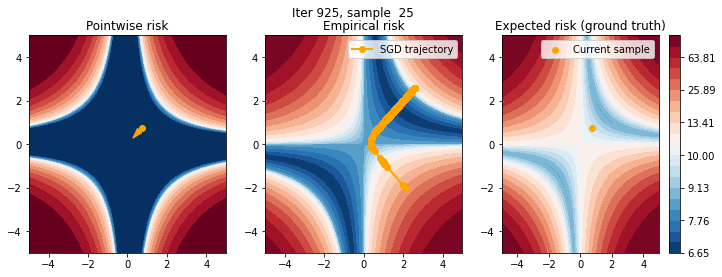

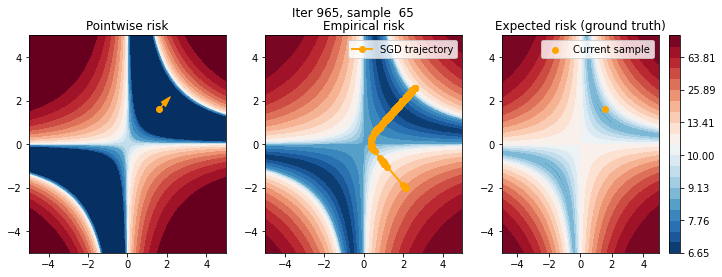

In [10]:
class LinearMLP(nn.Module):
    def __init__(self, w=None):
        super(LinearMLP, self).__init__()
        self.w1 = Parameter(torch.FloatTensor((1, )))
        self.w2 = Parameter(torch.FloatTensor((1, )))
        if w is None:
            self.reset_parameters()
        else:
            self.set_parameters(w)

    def reset_parameters(self):
        self.w1.data.uniform_(-.1, .1)
        self.w2.data.uniform_(-.1, .1)

    def set_parameters(self, w):
        self.w1.data[0] = w[0]
        self.w2.data[0] = w[1]

    def forward(self, x):
        return self.w1 * self.w2 * x


def expected_risk_linear_mlp(w1, w2):
    return .5 * (8 / 3 - (8 / 3) * w1 * w2 + 2 / 3 * w1 ** 2 * w2 ** 2) + std ** 2


W1, W2, risks, emp_risk, exp_risk = make_grids(
    x, y, LinearMLP, expected_risk_func=expected_risk_linear_mlp)
init = torch.FloatTensor([2, -1.9])
model = LinearMLP(init)
iterate_rec, grad_rec = train(model, x, y, lr=.05, n_epochs=10)
n_iter = len(iterate_rec)
for iter_ in list(range(5)) + list(range(5, n_iter, 40)):
    sample = iter_ % n_samples
    plot_map(W1, W2, risks, emp_risk, exp_risk, sample, iter_)

## Utilities to generate the slides figures

In [0]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(8, 8))
all_risks = np.concatenate((empirical_risk.ravel(),                            expected_risk.ravel()))

x_center, y_center = empirical_risk.shape[0] // 2, empirical_risk.shape[1] // 2
risk_at_center = expected_risk[x_center, y_center]
low_levels = np.percentile(all_risks[all_risks <= risk_at_center],
                            q=np.linspace(0, 100, 11))
high_levels = np.percentile(all_risks[all_risks > risk_at_center],
                             q=np.linspace(10, 100, 10))
levels = np.concatenate((low_levels, high_levels))
norm = LevelsNormalize(levels=levels)

cmap = plt.get_cmap('RdBu_r')

ax.set_title('Pointwise risk')


def animate(i):
     for c in ax.collections:
         c.remove()
     for l in ax.lines:
         l.remove()
     for p in ax.patches:
         p.remove()
     risk_levels = levels.copy()
     risk_levels[0] = min(risks[i].min(), risk_levels[0])
     risk_levels[-1] = max(risks[i].max(), risk_levels[-1])
     ax.contourf(W1, W2, risks[i], levels=risk_levels,
                  norm=norm, cmap=cmap)
     ax.plot(iterate_rec[:i + 1, 0], iterate_rec[:i + 1, 1],
              linestyle='-', marker='o', markersize=6,
              color='orange', linewidth=2, label='SGD trajectory')
     return []

anim = FuncAnimation(fig, animate,# init_func=init,
                      frames=100, interval=300, blit=True)
anim.save("stochastic_landscape_minimal_mlp.mp4")
plt.close(fig)


In [15]:
HTML(anim.to_html5_video())

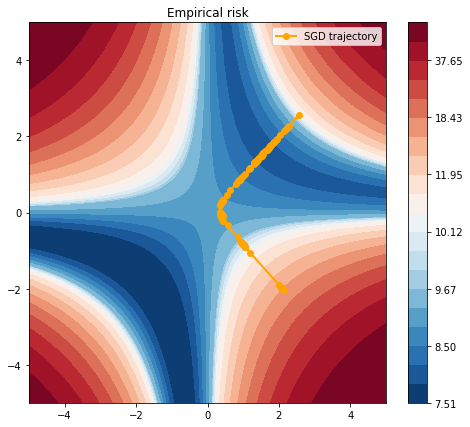

In [14]:
fig, ax = plt.subplots(figsize=(8, 7))
cf = ax.contourf(W1, W2, empirical_risk, levels=levels, norm=norm, cmap=cmap)
ax.plot(iterate_rec[:100 + 1, 0], iterate_rec[:100 + 1, 1],
         linestyle='-', marker='o', markersize=6,
          color='orange', linewidth=2, label='SGD trajectory')
ax.legend()
plt.colorbar(cf, ax=ax)
ax.set_title('Empirical risk')
fig.savefig('empirical_loss_landscape_minimal_mlp.png')